# RLHFは通常のRLより難しいのか？

参考
* [Is RLHF More Difficult than Standard RL?](https://arxiv.org/abs/2306.14111)

RLHFでは報酬関数を人間の嗜好から推定し，その上で強化学習しないといけません．これは単純に普通の強化学習より難しそうです．
本当にそうでしょうか？

表記：よくあるepisodic finite horizon MDPです．
また，報酬関数が状態行動ではなく軌跡に割り当てられてる場合についても考えます．その場合は$r^{\star}:(\mathcal{S} \times \mathcal{A})^H \rightarrow[0, H]$とします．

RLHFの問題設定として，次のcomparison oracleを与えます．

$$
o \sim \operatorname{Ber}\left(\sigma\left(r^{\star}\left(\tau_1\right)-r^{\star}\left(\tau_2\right)\right)\right) \text {, }
$$

これは軌跡$\tau_1$と$\tau_2$を比較し，リンク関数$\sigma(\cdot)$によって０〜１の値を返し，さらにベルヌーイ分布に従って確率的にバイナリ値が返ってきます．

もし$o=1$なら，$\tau_1 \succ \tau_2$であることを意味します．

## 準備

**$\epsilon'$-independentな状態**

状態$x_i$は，それ以前の系列$\left\{x_1, \ldots, x_{i-1}\right\}$について，

$$
\sqrt{\sum_{j=1}^{i-1}\left(\left(f_i-g_i\right)\left(x_j\right)\right)^2} \leq \epsilon^{\prime} \quad \text { and } \quad\left|\left(f_i-g_i\right)\left(x_i\right)\right| \geq \epsilon^{\prime}
$$

を満たす$f_i, g_i \in \mathcal{F}$が存在すれば，$x_i$は$\epsilon^{\prime}$-independentであると言います．

**直感**

$i$以前の$x_1, x_2, \dots, x_{i-1}$では関数$f_i$と$g_i$はagreeしているけれど，$x_i$ではdisagreeです．

例えば下の図では$i=8$で，$f$と$g$はdisagreeします．


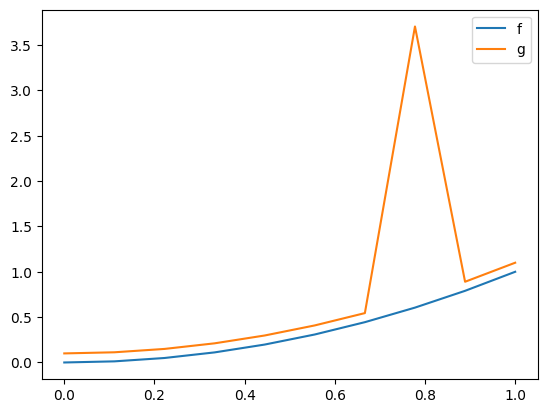

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0, 1.0, 10)

f = x ** 2
g = x ** 2 + 0.1

g[7] += 3

plt.plot(x, f, label="f")
plt.plot(x, g, label="g")

plt.legend()


---

**Eluder dimension**

関数クラス
$\mathcal{F} \subseteq(\mathcal{X} \rightarrow \mathbb{R})$
について，そのEluder dimension $\operatorname{dim}_{\mathrm{E}}(\mathcal{F}, \epsilon)$
は次の$\epsilon' \geq \epsilon$が存在する最も長い系列$\left\{x_1, x_2, \ldots, x_n\right\} \subseteq \mathcal{X}$の長さのことです．

* 任意の$i\in [n]$について，$x_i$が$\epsilon'$-independentになる．

**直感**

Eluder dimensionは，関数クラス$\mathcal{F}$の中の関数$f$を他の$g$と区別するために「間違える回数」の最悪ケースを表しています．


## 仮定など

---

**報酬のrealizability**

次を仮定します：

* 報酬関数のクラス$\mathcal{R}$は既知
* 真の報酬関数は$r^\star \in \mathcal{R}$である．

また，バイアスが載った報酬関数のクラスを$\overline{\mathcal{R}}:=\{r+c \mid c \in[-H, 0], r \in \mathcal{R}\}$と定義します．
これはRLHFするため，バイアスが載った報酬しか学習できないためです．

また，次のロバストアルゴリズムは既知であるとします．

---

**ロバストRL**

アルゴリズム$\mathscr{A}$は次を満たすとき，$g(\epsilon)$-ロバストであり，サンプル効率$\mathcal{C}(\epsilon, \delta)$を持つと言います．

* 軌跡$\tau$が$\|\varepsilon(\tau)\|_{\infty} \leq g(\epsilon)$分だけずらされても，確率$1-\delta$以上で，$\mathcal{C}(\epsilon, \delta)$のサンプルを使って$\epsilon$-最適な方策を返す．

---

このようなロバストアルゴリズムは実は簡単に構築できます（また，任意のテーブル形式のRLなどはロバストです）．次の補題が成立します．


---

**補題**

任意のサンプル効率$\mathcal{C}(\epsilon, \delta)$のアルゴリズム$\mathscr{A}$は，サンプル効率$\mathcal{C}(\epsilon, \delta / 3)$かつ$\frac{1}{\mathcal{C}(\epsilon, \delta)}$-ロバストなアルゴリズムに変形できる．

**証明**

報酬を直接使う代わりに，次のように$+2H$と$-2H$に二値化した報酬を使う状況を考えます（Unbiasedです）：

$$b(r):=\left\{2 H: \frac{1}{2}+\frac{r}{4 H},-2 H: \frac{1}{2}-\frac{r}{4 H}\right\}$$

真の報酬を$r^\star$とします．
サンプル効率の定義から，アルゴリズム$\mathscr{A}$は，

* $b(r^\star)$を使って，$K:=\mathcal{C}(\epsilon, \delta)$エピソードで，確率$1-\delta$以上で$r^\star$に対して$\epsilon$-最適な方策$\pi_0$を出力する．

ここで，$\mathscr{A}$を$b(r^\star)$上で走らせて得られる軌跡を$\tau_1, \cdots, \tau_K$とします．
また，軌跡$\tau_k$について，報酬のラベルが$b(r^\star(\tau_k))$から$b(r_k')$に，

$$\left|r_k^{\prime}-r^{\star}\left(\tau_k\right)\right| \leq \epsilon^{\prime}:=(\mathcal{C}(\epsilon, \delta))^{-1}$$

によって摂動される状況を考えます．また，$\mathscr{A}$によって出力される方策を$\pi'$とします．このとき，

$$
\left|\ln \left(\frac{b\left(r^{\star}\left(\tau_k\right)\right)=2 H}{b\left(r_k^{\prime}\right)=2 H}\right)\right| \leq \ln \left(1+\frac{\epsilon^{\prime}}{H}\right)
$$

であり，

$$
\sup _{\vec{r} \in\{2 H,-2 H\}^K}\left|\sum_{k=1}^K \ln \left(\frac{b\left(r^{\star}\left(\tau_1\right)\right), \cdots, b\left(r^{\star}\left(\tau_K\right)\right)=\vec{r}}{b\left(r_1^{\prime}\right), \cdots, b\left(r_K^{\prime}\right)=\vec{r}}\right)\right| \leq K \ln \left(1+\frac{\epsilon^{\prime}}{H}\right) \leq \frac{K \epsilon^{\prime}}{H} \leq 1
$$

が成立します．よって，$\pi$と$\hat{\pi}$の密度比は$e$でバウンドされ，$\hat{\pi}$が$\epsilon$最適ではない確率は$3\delta$で抑えられます．

---

**リンク関数の仮定**

リンク関数は既知であり，
$\sigma(0)=\frac{1}{2} ;$ for $x \in[-H, H], \sigma^{\prime}(x) \geq \alpha>0$
とします．

これがない場合，実は最適方策が学習できません．Lemma2とLemma3を参照してください．


## RLHFのアルゴリズム

次のフレームワークに従ってアルゴリズムを走らせます．

![RLHF](figs/RLHF.png)

**Preference-to-Reward アルゴリズムの疑似コード**

1. $\mathcal{B}_r \leftarrow \mathcal{R}, \mathcal{D} \leftarrow\{\}, \mathcal{D}_{\text {hist }} \leftarrow\{\}$
    * $\mathcal{B}_{r}$は現時点での報酬関数のクラスの推定です
    * $\mathcal{D}$はオラクルに聞いたやつだけを貯めます
    * $\mathcal{D}_{\text{hist}}$は今までの軌跡と報酬の推定値が全部入ってるやつです．
2. ランダムな方策を走らせて$\tau_0$を取得します

続いて，クエリされた軌跡$\tau$について考えます．
1. もし$(\hat{r}, \tau) \in \mathcal{D}_{\text {hist }}$であれば，$\hat{r}$を返します．
2. そうでないならば，
   1. もし$\max _{r, r^{\prime} \in \mathcal{B}_r}\left(r(\tau)-r\left(\tau_0\right)\right)-\left(r^{\prime}(\tau)-r^{\prime}\left(\tau_0\right)\right)<2 \epsilon_0$であれば，（つまり，報酬関数のクラス内で意見が別れなければ）
      1. $\hat{r} \leftarrow r(\tau)-r\left(\tau_0\right)$ for an arbitrary $r \in \mathcal{B}_r$ 
      2. $\mathcal{D}_{\text {hist }} \leftarrow \mathcal{D}_{\text {hist }} \cup(\hat{r}, \tau)$
   2. そうでないならば，
      1. $\tau$ vs $\tau_0$について，comparison oracleに$m$解クエリを投げて，comparisonの結果の期待値$\bar{o}$を計算します．
      2. $\hat{r} \leftarrow \operatorname{argmin}_{x \in[-H, H]}|\sigma(x)-\bar{o}|, \quad \mathcal{D} \leftarrow \mathcal{D} \cup(\hat{r}, \tau), \quad \mathcal{D}_{\text {hist }} \leftarrow \mathcal{D}_{\text {hist }} \cup(\hat{r}, \tau)$
      3. $\mathcal{B}_r \leftarrow\left\{r \in \mathcal{B}_r: \sum_{(\hat{r}, \tau) \in \mathcal{D}}\left(r(\tau)-r\left(\tau_0\right)-\hat{r}\right)^2 \leq \beta\right\}$


このとき，次が成立します．

---

**定理**

* $\epsilon_0=g(\epsilon) / 2$，$d_{\overline{\mathcal{R}}}=\operatorname{dim}_{\mathrm{E}}\left(\overline{\mathcal{R}}, \epsilon_0\right)$ and $m=\Theta\left(\frac{d_{\overline{\mathcal{R}}} \ln \left(d_{\overline{\mathcal{R}}} / \delta\right)}{\epsilon_0^2 \alpha^2}\right)$とします
* $\beta=\frac{\epsilon_0^2}{4}$とします．
* $\mathscr{A}$は$g(\epsilon)$-ロバストなRLアルゴリズムとし，そのサンプル効率を$\mathcal{C}(\epsilon, \delta)$とします．

このとき，$\mathscr{A}$をPreference-to-rewardアルゴリズムと併用した場合，$\mathcal{C}(\epsilon, \delta)$個のサンプルと$\widetilde{\mathcal{O}}\left(\frac{d_r^2}{\alpha^2 g(\epsilon)^2}\right)$個のクエリで，確率$1-2\delta$以上で$\epsilon$-最適な方策が見つかります．

---

これは軌跡に対して報酬を返すオラクルになってますが，別に状態報酬ペアに対するオラクルでも問題ありません．
状態行動版のアルゴリズムについて考えてみます：

**状態行動版の疑似コード**

1. $\mathcal{B}_r \leftarrow \mathcal{R}, \mathcal{D} \leftarrow\{\}, \mathcal{D}_{\text {hist }} \leftarrow\{\}$
    * $\mathcal{B}_{r}$は現時点での報酬関数のクラスの推定です
    * $\mathcal{D}$はオラクルに聞いたやつだけを貯めます
    * $\mathcal{D}_{\text{hist}}$は今までの状態行動と報酬の推定値が全部入ってるやつです．
2. ランダムな方策を走らせて状態行動対$(s_0, a_0)$を取得します

続いて，クエリされた状態行動$(s, a)$について考えます．
1. もし$(\hat{r}, (s, a)) \in \mathcal{D}_{\text {hist }}$であれば，$\hat{r}$を返します．
2. そうでないならば，
   1. もし$\max _{r, r^{\prime} \in \mathcal{B}_r}\left(r(s, a)-r\left(s_0, a_0\right)\right)-\left(r^{\prime}(s, a)-r^{\prime}\left(s_0, a_0\right)\right)<2 \epsilon_0$であれば，（つまり，報酬関数のクラス内で意見が別れなければ）
      1. $\hat{r} \leftarrow r(s, a)-r\left(s_0, a_0\right)$ for an arbitrary $r \in \mathcal{B}_r$ 
      2. $\mathcal{D}_{\text {hist }} \leftarrow \mathcal{D}_{\text {hist }} \cup(\hat{r},(s, a))$
   2. そうでないならば，
      1. $(s, a)$ vs $(s_0, a_0)$について，comparison oracleに$m$回クエリを投げて，comparisonの結果の期待値$\bar{o}$を計算します．
      2. $\hat{r} \leftarrow \operatorname{argmin}_{x \in[-H, H]}|\sigma(x)-\bar{o}|, \quad \mathcal{D} \leftarrow \mathcal{D} \cup(\hat{r}, (s, a)), \quad \mathcal{D}_{\text {hist }} \leftarrow \mathcal{D}_{\text {hist }} \cup(\hat{r}, (s, a))$
      3. $\mathcal{B}_r \leftarrow\left\{r \in \mathcal{B}_r: \sum_{(\hat{r}, (s, a)) \in \mathcal{D}}\left(r(s, a)-r\left(s_0, a_0\right)-\hat{r}\right)^2 \leq \beta\right\}$
3. 最後に$\hat{r}$を返します

**$\operatorname{argmin}_{x \in[-H, H]}|\sigma(x)-\bar{o}|$の実現**

$\sigma(x) = \frac{1}{1 + \exp (-x)}$
の場合，
$$
\begin{aligned}
&\frac{1}{1 + \exp (-x)} = \bar{o}\\
\Leftrightarrow
&1 = \bar{o} + \bar{o}\exp (-x)\\
\Leftrightarrow
&\frac{1 - \bar{o}}{\bar{o}} = \exp (-x)\\
\Leftrightarrow
&\log\left(\frac{\bar{o}}{1 - \bar{o}}\right) = x
\end{aligned}
$$

として$\operatorname{argmin}_{x \in[-H, H]}|\sigma(x)-\bar{o}|$が計算できます．


**$\mathcal{B}_r$の実現**

$\mathcal{B}_r$を$S\times A\times [2]$の行列として，
各$\mathcal{B}_r(s, a)$には$(s, a)$でとり得る報酬の最大値と最小値を入れることにしましょう．

そうすると，
$\mathcal{B}_r \leftarrow\left\{r \in \mathcal{B}_r: \sum_{(\hat{r}, (s, a)) \in \mathcal{D}}\left(r(s, a)-r\left(s_0, a_0\right)-\hat{r}\right)^2 \leq \beta\right\}$
の操作では，

$\mathcal{B}_r(s, a)$に$r(s_0, a_0) + \hat{r} \pm \frac{\epsilon_0}{2}$を入れれば良いことになります．

また，このとき$\max _{r, r^{\prime} \in \mathcal{B}_r}\left(r(s, a)-r\left(s_0, a_0\right)\right)-\left(r^{\prime}(s, a)-r^{\prime}\left(s_0, a_0\right)\right)$

は$B_r(s, a)_{\max}-B_r\left(s_0, a_0\right)_{\min}$から$B_r(s, a)_{\min}-B_r\left(s_0, a_0\right)_{\max}$を引けば良さそうです．

In [50]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple, Optional
from jax.random import PRNGKey

key = PRNGKey(0)

S = 10  # 状態集合のサイズ
A = 3  # 行動集合のサイズ
S_set = jnp.arange(S)  # 状態集合
A_set = jnp.arange(A)  # 行動集合
H = 5  # ホライゾン

# 報酬行列を適当に作ります（面倒なので報酬は時定常とします）
key, _ = jax.random.split(key)
rew = jax.random.uniform(key=key, minval=-1, maxval=1, shape=(S, A))
assert rew.shape == (S, A)


# 遷移確率行列を適当に作ります（面倒なので時定常とします）
key, _ = jax.random.split(key)
P = jax.random.uniform(key=key, shape=(S*A, S))
P = P / jnp.sum(P, axis=-1, keepdims=True)  # 正規化して確率にします
P = P.reshape(S, A, S)
np.testing.assert_allclose(P.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


# 初期状態分布を適当に作ります
key, _ = jax.random.split(key)
mu = jax.random.uniform(key, shape=(S,))
mu = mu / jnp.sum(mu)
np.testing.assert_allclose(mu.sum(axis=-1), 1, atol=1e-6)  # ちゃんと確率行列になっているか確認します


# 状態集合, 行動集合, 割引率, 報酬行列, 遷移確率行列が準備できたのでMDPのクラスを作ります

class MDP(NamedTuple):
    S_set: jnp.array  # 状態集合
    A_set: jnp.array  # 行動集合
    H: int  # ホライゾン
    rew: jnp.array  # 報酬行列
    P: jnp.array  # 遷移確率行列
    mu: jnp.array  # 初期分布
    optimal_Q: Optional[jnp.ndarray] = None  # 最適Q値

    @property
    def S(self) -> int:  # 状態空間のサイズ
        return len(self.S_set)

    @property
    def A(self) -> int:  # 行動空間のサイズ
        return len(self.A_set)


mdp = MDP(S_set, A_set, H, rew, P, mu)

print("状態数：", mdp.S)
print("行動数：", mdp.A)
print("ホライゾン：", mdp.H)

状態数： 10
行動数： 3
ホライゾン： 5


In [78]:
link_fun = lambda x: 1 / (1 + np.exp(-x))
eps_0 = 0.1
s0, a0 = 0, 0
m = 100


def initialize():
    D_hist = np.zeros((S, A))
    D_hist[:, :] = np.nan
    D = np.zeros((S, A))
    D[:, :] = np.nan

    # 各状態行動でとり得る報酬の最大と最小値を保持しておきます．
    # 最初は適当な値を入れておきます．
    B_r = np.zeros((S, A, 2))
    B_r[:, :, 0] = 1
    B_r[:, :, 1] = - 1

    return D_hist, D, B_r


def ask_oracle(s, a, m):
    r_gap = rew[s, a] - rew[s0, a0]
    o = np.random.binomial(1, link_fun(r_gap), size=m).mean()
    return o


def update_B_r(B_r, s, a, r_hat):
    B_r[s, a, 0] - B_r[s0, a0, 0] - r_hat


def pref_to_rew(D_hist, D, B_r, s, a, m):
    num_ask_oracle = 0

    if not np.isnan(D_hist[s, a]):
        return D_hist[s, a], num_ask_oracle

    else:
        r_1 = B_r[s, a].max() 
        r0_1 = B_r[s0, a0].min() 
        r_gap_1 = r_1 - r0_1

        r_2 = B_r[s, a].min()
        r0_2 = B_r[s0, a0].max() 
        r_gap_2 = r_2 - r0_2


        if r_gap_1 - r_gap_2 < 2 * eps_0:
            r_hat = r_gap_1
            D_hist[s, a] = r_hat

        else:
            o = ask_oracle(s, a, m)
            r_hat = np.log(o / (1 - o))
            B_r[s, a, 0] = B_r[s0, a0, 0] + r_hat + eps_0 / 2
            B_r[s, a, 1] = B_r[s0, a0, 0] + r_hat - eps_0 / 2
            D_hist[s, a] = r_hat
            D[s, a] = r_hat
            num_ask_oracle = m

        return r_hat, num_ask_oracle
            
# テスト
D_hist, D, B_r = initialize()
pref_to_rew(D_hist, D, B_r, 1, 2, m)

(1.0459685551826876, 100)

In [65]:
from functools import partial
import jax
import chex
import random


@jax.jit
def compute_greedy_policy(Q: jnp.ndarray):
    """Q関数の貪欲方策を返します

    Args:
        Q (jnp.ndarray): (HxSxA)の行列

    Returns:
        greedy_policy (jnp.ndarray): (HxSxA)の行列
    """
    greedy_policy = jnp.zeros_like(Q)
    H, S, A = Q.shape
    
    def body_fn(i, greedy_policy):
        greedy_policy = greedy_policy.at[i, jnp.arange(S), Q[i].argmax(axis=-1)].set(1)
        return greedy_policy

    greedy_policy = jax.lax.fori_loop(0, H, body_fn, greedy_policy)
    chex.assert_shape(greedy_policy, (H, S, A))
    return greedy_policy


@partial(jax.jit, static_argnames=("H", "S", "A"))
def _compute_optimal_Q(mdp: MDP, H: int, S: int, A: int):
    """ベルマン最適作用素をホライゾン回走らせて最適価値関数を動的計画法で計算します。
    Args:
        mdp (MDP)

    Returns:
        optimal_Q (jnp.ndarray): (HxSxA)の行列
    """

    def backup(i, optimal_Q):
        h = H - i - 1
        max_Q = optimal_Q[h+1].max(axis=1)
        next_v = mdp.P @ max_Q
        chex.assert_shape(next_v, (S, A))
        optimal_Q = optimal_Q.at[h].set(mdp.rew + next_v)
        return optimal_Q
    
    optimal_Q = jnp.zeros((H+1, S, A))
    optimal_Q = jax.lax.fori_loop(0, mdp.H, backup, optimal_Q)
    return optimal_Q[:-1]

compute_optimal_Q = lambda mdp: _compute_optimal_Q(mdp, mdp.H, mdp.S, mdp.A)


@jax.jit
def compute_policy_Q(mdp: MDP, policy: jnp.ndarray):
    """ベルマン期待作用素をホライゾン回走らせて価値関数を動的計画法で計算します。
    Args:
        mdp (MDP)
        policy (np.ndarray): (HxSxA)の行列

    Returns:
        optimal_Q (jnp.ndarray): (HxSxA)の行列
    """
    H, S, A = policy.shape

    def backup(i, policy_Q):
        h = H - i - 1
        max_Q = (policy[h+1] * policy_Q[h+1]).sum(axis=1)
        next_v = mdp.P @ max_Q
        chex.assert_shape(next_v, (S, A))
        policy_Q = policy_Q.at[h].set(mdp.rew + next_v)
        return policy_Q
    
    policy_Q = jnp.zeros((H+1, S, A))
    policy_Q = jax.lax.fori_loop(0, mdp.H, backup, policy_Q)
    return policy_Q[:-1]


@jax.jit
def compute_optimality_gap(mdp: MDP, policy: np.ndarray):
    policy_Q = compute_policy_Q(mdp, policy)
    optimality_gap = jnp.abs(mdp.optimal_Q - policy_Q).max()
    return optimality_gap


def sample_next_state(mdp: MDP, s: int, a: int):
    """ sample next state according to the transition matrix P
    Args:
        mdp: MDP
        s: int
        a: int
    Returns:
        next_s: int
    """
    probs = np.array(mdp.P[s, a])
    return np.random.choice(mdp.S_set, p=probs)


def sample_eps_greedy_act(mdp: MDP, q_s: np.array, eps: float):
    if random.random() < eps:
        return random.randint(0, mdp.A-1)
    else:
        return q_s.argmax()

mdp = mdp._replace(optimal_Q=compute_optimal_Q(mdp))

In [80]:
from tqdm import tqdm


def EpsilonGreedyVI_RLHF(mdp: MDP, K: int):
    # 真の報酬は未知ですが，RLHFで学習します．
    S, A, H = mdp.S, mdp.A, mdp.H
    D_hist, D, B_r = initialize()

    # MDPが定常なのでHは省略します
    visit_SA = np.zeros((S, A))
    visit_SAS = np.zeros((S, A, S))
    P_approx = np.ones((S, A, S)) / S
    policy = np.ones((S, A)) / A
    rew_approx = np.zeros((S, A))

    init_s = 0
    optimal_V = mdp.optimal_Q[0, init_s].max()
    optimality_gaps = []

    for k in tqdm(range(K)):
        s = init_s

        # 探索をします　
        for h in range(H):
            a = np.random.randint(A)
            visit_SA[s, a] += 1
            next_s = sample_next_state(mdp, s, a)
            visit_SAS[s, a, next_s] += 1
            P_approx[s, a] = visit_SAS[s, a] / visit_SA[s, a]

            # RLHFで報酬を更新します
            rew_approx[s, a], _ = pref_to_rew(D_hist, D, B_r, s, a, m)
            s = next_s

        # 方策を更新します
        mdp_approx = mdp._replace(P=P_approx, rew=rew_approx)
        mdp_approx = mdp_approx._replace(optimal_Q=compute_optimal_Q(mdp_approx))
        policy = compute_greedy_policy(mdp_approx.optimal_Q)

        # リグレットを計算します
        policy_V = compute_policy_Q(mdp, policy)[0, init_s].max()
        optimality_gaps.append(optimal_V - policy_V)

    return optimality_gaps, visit_SA


K = 1000
eps_greedy_gaps, eps_greedy_visit_SA = EpsilonGreedyVI_RLHF(mdp, K)

100%|██████████| 1000/1000 [00:02<00:00, 413.26it/s]


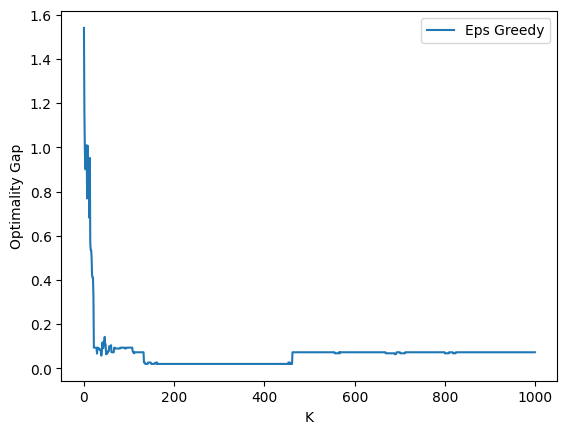

In [81]:
plt.plot(eps_greedy_gaps, label="Eps Greedy RLHF")
plt.ylabel("Optimality Gap")
plt.xlabel("K")
plt.legend()

ちゃんとRLHFできてますね．良かったよかった．